# ARIMA Time Series Forecasting for Inpatient Waiting Lists

## Workflow:
1. Data Loading and Preparation
2. Stationarity Testing (ADF & KPSS)
3. Differencing (if needed)
4. ACF/PACF Analysis
5. ARIMA Model Selection
6. Model Diagnostics
7. Forecasting and Evaluation
8. Future Forecasts


# 1. Imports and Setup

In [148]:

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from pathlib import Path
import datetime as dt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")



# 2. Helper Functions


In [149]:

def ensure_outdir(base="/Users/chandhiny/Revised Code CS7CS5/outputs", model="arima"):
    """Create output directory with timestamp"""
    stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    outdir = Path(base) / f"{model}_{stamp}"
    outdir.mkdir(parents=True, exist_ok=True)
    return outdir

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = np.finfo(float).eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def mase(y_true, y_pred, y_naive):
    """Mean Absolute Scaled Error"""
    mae_model = mean_absolute_error(y_true, y_pred)
    mae_naive = mean_absolute_error(y_true, y_naive)
    return mae_model / mae_naive if mae_naive != 0 else np.inf

def naive_forecast(series):
    """Naive forecast (previous value)"""
    return np.r_[np.nan, series[:-1]]

def prediction_interval_coverage(true_vals, lower, upper):
    """Calculate prediction interval coverage"""
    inside = (true_vals >= lower) & (true_vals <= upper)
    return 100.0 * np.mean(inside)


# 3. Load and Prepare Dataset

In [150]:

INPUT_CSV = "/Users/chandhiny/Revised Code CS7CS5/monthly_inpatient_national_total.csv"
outdir = ensure_outdir()

# Load data
df = pd.read_csv(INPUT_CSV)
df.columns = [c.strip() for c in df.columns]

print("\n Dataset Preview:")
display(df.head())
print(f"\n Dataset shape: {df.shape}")
print(f" Date range: {df['Month Year'].min()} to {df['Month Year'].max()}")

# Prepare time series
df['ds'] = pd.to_datetime(df['Month Year'], format='%m-%Y')
df = df.sort_values('ds').reset_index(drop=True)
df['y'] = pd.to_numeric(df['Total Patients Waiting List'], errors='coerce')
df = df.dropna(subset=['ds', 'y'])

print(f"\n Clean dataset shape: {df.shape}")
print(f" Value range: {df['y'].min():,.0f} to {df['y'].max():,.0f}")



 Dataset Preview:


,Month Year,Total Patients Waiting List
0,01-2022,77816
1,02-2022,78367
2,03-2022,80470
3,04-2022,79944
4,05-2022,79690



 Dataset shape: (44, 2)
 Date range: 01-2022 to 12-2024

 Clean dataset shape: (44, 4)
 Value range: 77,816 to 100,273


# 4. Train/Test Split


In [151]:
# 4. Train/Test Split
TEST_MONTHS = 12
split_idx = len(df) - TEST_MONTHS

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f" Training data: {len(train_df)} months → {train_df['ds'].min().strftime('%b %Y')} to {train_df['ds'].max().strftime('%b %Y')}")
print(f" Test data:     {len(test_df)} months → {test_df['ds'].min().strftime('%b %Y')} to {test_df['ds'].max().strftime('%b %Y')}")

# Extract time series
train_ts = train_df.set_index('ds')['y']
test_ts = test_df.set_index('ds')['y']

print(f"\n Time series prepared:")
print(f"   Training: {len(train_ts)} observations")
print(f"   Test: {len(test_ts)} observations")


 Training data: 32 months → Jan 2022 to Aug 2024
 Test data:     12 months → Sep 2024 to Aug 2025

 Time series prepared:
   Training: 32 observations
   Test: 12 observations


# Time Series Plot


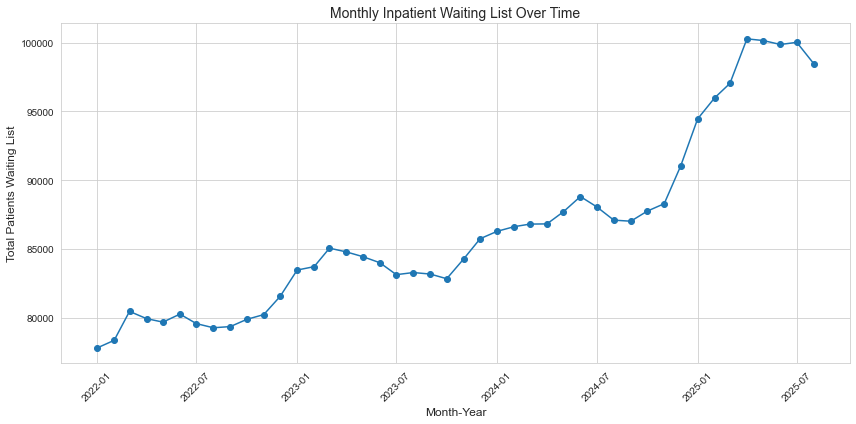

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("monthly_inpatient_national_total.csv")

# Convert Month Year to datetime
df['ds'] = pd.to_datetime(df['Month Year'], format="%m-%Y")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['Total Patients Waiting List'], marker='o', linestyle='-')
plt.title("Monthly Inpatient Waiting List Over Time", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Total Patients Waiting List", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Stationarity tests


In [153]:

def adf_test(series, name="Series"):
    """Augmented Dickey-Fuller test"""
    result = adfuller(series, autolag='AIC')
    print(f"\n ADF Test - {name}")
    print(f"   Test Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.4f}")
    print(f"   Critical Values: {result[4]}")
    print(f"   Result: {' Stationary' if result[1] < 0.05 else ' Non-Stationary'}")
    return result[1] < 0.05

def kpss_test(series, name="Series"):
    """KPSS test"""
    try:
        result = kpss(series, regression='c', nlags='auto')
        print(f"\n KPSS Test - {name}")
        print(f"   Test Statistic: {result[0]:.4f}")
        print(f"   p-value: {result[1]:.4f}")
        print(f"   Critical Values: {result[3]}")
        print(f"   Result: {'Stationary' if result[1] > 0.05 else ' Non-Stationary'}")
        return result[1] > 0.05
    except Exception as e:
        print(f"\n KPSS Test failed: {e}")
        return None

# Test original series
print(" STATIONARITY TESTS")
print("=" * 50)
adf_stationary = adf_test(train_ts, "Original Series")
kpss_stationary = kpss_test(train_ts, "Original Series")

if not adf_stationary:
    print("\n Series is non-stationary. Differencing required.")


 STATIONARITY TESTS

 ADF Test - Original Series
   Test Statistic: -1.3514
   p-value: 0.6053
   Critical Values: {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}
   Result:  Non-Stationary

 KPSS Test - Original Series
   Test Statistic: 0.8297
   p-value: 0.0100
   Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
   Result:  Non-Stationary

 Series is non-stationary. Differencing required.


# 6. Differencing and Stationarity Check


In [154]:
if not adf_stationary:
    # First-order differencing
    train_diff = train_ts.diff().dropna()
    
    print("\nAFTER FIRST-ORDER DIFFERENCING")
    print("=" * 50)
    
    adf_diff_stationary = adf_test(train_diff, "Differenced Series")
    kpss_diff_stationary = kpss_test(train_diff, "Differenced Series")
    
    if adf_diff_stationary:
        print("\nSeries is now stationary after differencing!")
        d = 1  # Differencing order
    else:
        print("\nSeries still non-stationary. May need higher order differencing.")
        d = 1  # Start with 1, can be adjusted
else:
    print("\n Original series is already stationary!")
    train_diff = train_ts
    d = 0

print(f"\nDifferencing order (d): {d}")
print(f"Differenced series length: {len(train_diff)}")



AFTER FIRST-ORDER DIFFERENCING

 ADF Test - Differenced Series
   Test Statistic: -4.3771
   p-value: 0.0003
   Critical Values: {'1%': -3.7529275211638033, '5%': -2.998499866852963, '10%': -2.6389669754253307}
   Result:  Stationary

 KPSS Test - Differenced Series
   Test Statistic: 0.0722
   p-value: 0.1000
   Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
   Result: Stationary

Series is now stationary after differencing!

Differencing order (d): 1
Differenced series length: 31


# 7. ACF and PACF Analysis


ACF: using 24 lags
PACF: using 14 lags (safe limit for n=31)


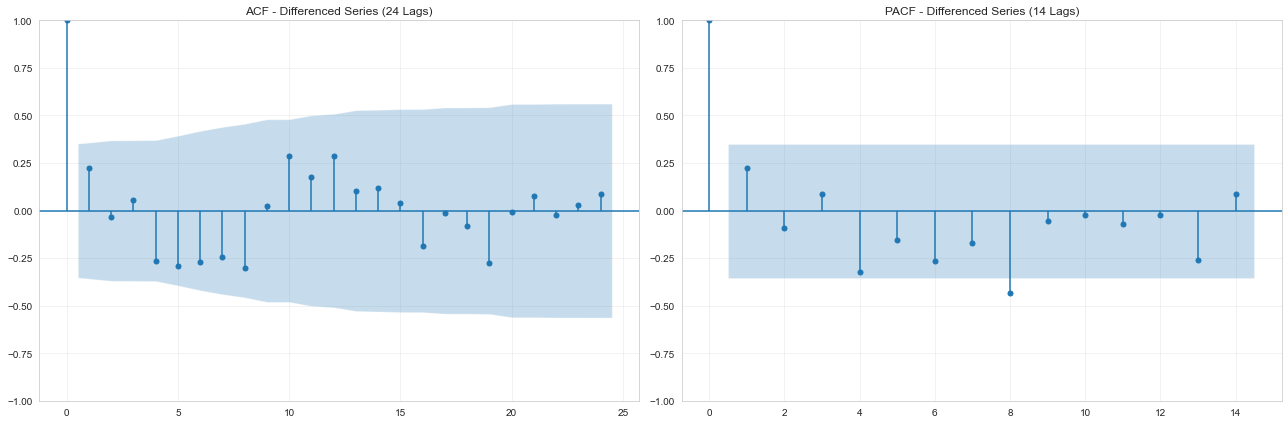

ACF/PACF Interpretation:
   - ACF: Look for spikes to determine MA(q)
   - PACF: Look for spikes to determine AR(p)


In [155]:
desired_lags = 24
n_obs = len(train_diff)

# Determine safe PACF lags (must be < 50% of sample size)
safe_pacf_lags = min(desired_lags, (n_obs // 2) - 1)

if n_obs >= 25:
    print(f"ACF: using {desired_lags} lags")
    print(f"PACF: using {safe_pacf_lags} lags (safe limit for n={n_obs})")
    print("=" * 60)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # ACF Plot (up to 24 lags)
    plot_acf(train_diff, ax=axes[0], lags=desired_lags, alpha=0.05)
    axes[0].set_title(f"ACF - Differenced Series ({desired_lags} Lags)")
    axes[0].grid(True, alpha=0.3)

    # PACF Plot (safe limited lags)
    plot_pacf(train_diff, ax=axes[1], lags=safe_pacf_lags, method='ywm', alpha=0.05)
    axes[1].set_title(f"PACF - Differenced Series ({safe_pacf_lags} Lags)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("ACF/PACF Interpretation:")
    print("   - ACF: Look for spikes to determine MA(q)")
    print("   - PACF: Look for spikes to determine AR(p)")

else:
    print(f"\n⚠️ Series too short for 24 lags (n={n_obs}). Need at least 49 for full PACF.")

# 8. ARIMA Model Selection


In [156]:

print("ARIMA MODEL SELECTION")
print("=" * 50)

orders = [(0,d,0), (1,d,0), (0,d,1), (1,d,1), (2,d,1), (1,d,2), (2,d,2)]
results = []

for order in orders:
    try:
        model = ARIMA(train_ts, order=order).fit()
        results.append({
            'order': order,
            'aic': model.aic,
            'bic': model.bic,
            'model': model
        })
        print(f"ARIMA{order}: AIC={model.aic:.2f}, BIC={model.bic:.2f}")
    except Exception as e:
        print(f"ARIMA{order}: Failed - {str(e)[:50]}...")

if results:
   
    best_result = min(results, key=lambda x: x['aic'])
    best_model = best_result['model']
    best_order = best_result['order']
    
    print(f"   BEST MODEL: ARIMA{best_order}")
    print(f"   AIC: {best_result['aic']:.2f}")
    print(f"   BIC: {best_result['bic']:.2f}")
 
    #print("Model Summary:")
    #print(best_model.summary())
else:
    print("No models could be fitted successfully.")
    best_model = None
    best_order = None


ARIMA MODEL SELECTION
ARIMA(0, 1, 0): AIC=509.14, BIC=510.58
ARIMA(1, 1, 0): AIC=510.40, BIC=513.26
ARIMA(0, 1, 1): AIC=510.43, BIC=513.29
ARIMA(1, 1, 1): AIC=510.20, BIC=514.51
ARIMA(2, 1, 1): AIC=507.11, BIC=512.85
ARIMA(1, 1, 2): AIC=506.67, BIC=512.40
ARIMA(2, 1, 2): AIC=507.92, BIC=515.09
   BEST MODEL: ARIMA(1, 1, 2)
   AIC: 506.67
   BIC: 512.40


In [157]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define parameter ranges
p = d = q = range(0, 2)         # ARIMA orders
P = D = Q = range(0, 2)         # Seasonal orders
s = 12                          # Seasonal cycle (monthly)

# Create all combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

print("Searching best SARIMA(p,d,q)(P,D,Q,12) model based on AIC/BIC...\n")
results = []

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train_ts,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'model': result
            })
            print(f"SARIMA{order}x{seasonal_order} - AIC: {result.aic:.2f}, BIC: {result.bic:.2f}")
        except Exception as e:
            continue

# Find best model by AIC
best_result = min(results, key=lambda x: x['aic'])
best_model = best_result['model']
best_order = best_result['order']
best_seasonal_order = best_result['seasonal_order']

print("BEST SARIMA MODEL SELECTED:")
print(f"   Order: {best_order}")
print(f"   Seasonal Order: {best_seasonal_order}")
print(f"   AIC: {best_result['aic']:.2f}")
print(f"   BIC: {best_result['bic']:.2f}")
print("\nModel Summary:")
print(best_model.summary())

Searching best SARIMA(p,d,q)(P,D,Q,12) model based on AIC/BIC...

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 792.55, BIC: 793.98
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC: 465.93, BIC: 467.82
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC: 370.34, BIC: 371.28
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC: 138.06, BIC: 137.95
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC: 340.73, BIC: 342.72
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC: 347.63, BIC: 350.46
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC: 143.58, BIC: 143.74
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC: 124.15, BIC: 123.99
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC: 748.31, BIC: 751.11
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC: 449.15, BIC: 451.82
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC: 339.48, BIC: 341.27
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC: 118.80, BIC: 118.17
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC: 496.32, BIC: 499.31
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC: 473.61, BIC: 477.17
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC: 152.22, BIC: 152.46
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC: 117.61, BIC: 116.77
SARIMA(0, 1, 0)x(0, 0,

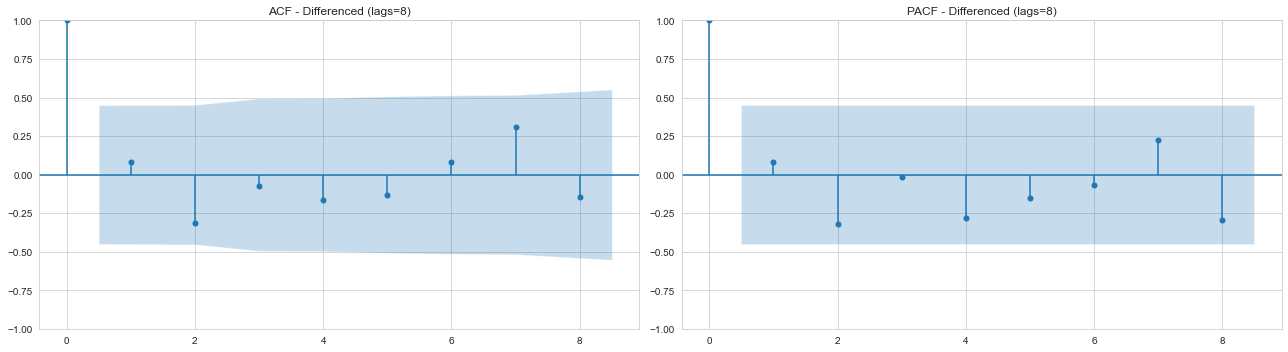

In [139]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure differencing is applied
diff_series = train_ts.diff().dropna()
seasonal_diff = train_ts.diff(12).dropna()
combined_diff = train_ts.diff().diff(12).dropna()

# Determine safe number of lags
max_lags = min(24, (len(combined_diff) // 2) - 1)

# Plot ACF/PACF safely
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(combined_diff, ax=axes[0], lags=max_lags)
axes[0].set_title(f"ACF - Differenced (lags={max_lags})")

plot_pacf(combined_diff, ax=axes[1], lags=max_lags, method="ywm")
axes[1].set_title(f"PACF - Differenced (lags={max_lags})")

plt.tight_layout()
plt.show()


SARIMA BEST MODEL FORECASTING AND EVALUATION
   MAE: 2,591
   RMSE: 3,439
   MAPE: 2.64%
   sMAPE: 2.70%
   MASE: 2.013
   95% Prediction Interval Coverage: 41.7%


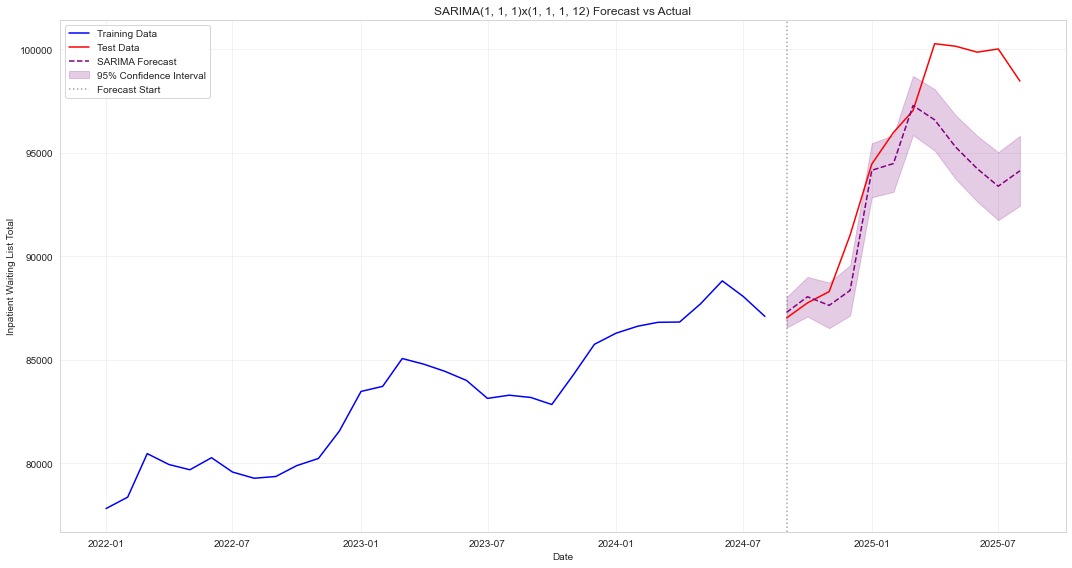

In [160]:
print("\nSARIMA BEST MODEL FORECASTING AND EVALUATION")
print("=" * 60)

# Forecast using best SARIMA model
forecast_steps = len(test_ts)
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Metrics
mae = mean_absolute_error(test_ts, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_ts, forecast_mean))
mape_val = mape(test_ts, forecast_mean)
smape_val = smape(test_ts, forecast_mean)
naive_pred = naive_forecast(np.concatenate([train_ts, test_ts]))[len(train_ts):]
mase_val = mase(test_ts, forecast_mean, naive_pred)
coverage = prediction_interval_coverage(test_ts, conf_int.iloc[:, 0], conf_int.iloc[:, 1])

print(f"   MAE: {mae:,.0f}")
print(f"   RMSE: {rmse:,.0f}")
print(f"   MAPE: {mape_val:.2f}%")
print(f"   sMAPE: {smape_val:.2f}%")
print(f"   MASE: {mase_val:.3f}")
print(f"   95% Prediction Interval Coverage: {coverage:.1f}%")

# Plot forecast
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label="Training Data", color='blue')
plt.plot(test_ts.index, test_ts.values, label="Test Data", color='red')
plt.plot(forecast_mean.index, forecast_mean.values, label="SARIMA Forecast", color='purple', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='purple', alpha=0.2, label='95% Confidence Interval')
plt.axvline(test_ts.index[0], color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
plt.title(f"SARIMA{best_order}x{best_seasonal_order} Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Inpatient Waiting List Total")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Model Diagnostics


MODEL DIAGNOSTICS


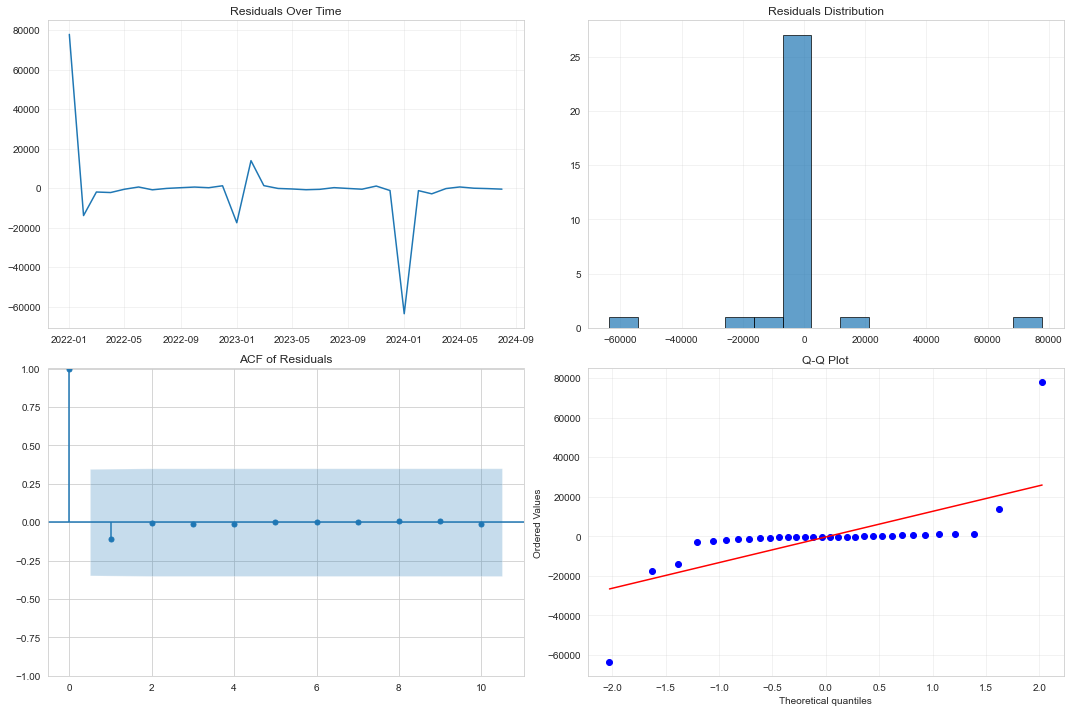


 Ljung-Box Test (lag 10):
   Statistic: 0.4325
   p-value: 1.0000
   Result:  No autocorrelation


In [133]:
# 9. Model Diagnostics
if best_model is not None:
    print("MODEL DIAGNOSTICS")
    print("=" * 50)
    
    # Residuals
    residuals = best_model.resid
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Residuals over time
    axes[0,0].plot(residuals)
    axes[0,0].set_title("Residuals Over Time")
    axes[0,0].grid(True, alpha=0.3)
    
    # Histogram of residuals
    axes[0,1].hist(residuals, bins=15, alpha=0.7, edgecolor='black')
    axes[0,1].set_title("Residuals Distribution")
    axes[0,1].grid(True, alpha=0.3)
    
    # ACF of residuals
    plot_acf(residuals, ax=axes[1,0], lags=min(10, len(residuals)//2-1))
    axes[1,0].set_title("ACF of Residuals")
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title("Q-Q Plot")
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Ljung-Box test for residual autocorrelation
    try:
        lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
        print(f"\n Ljung-Box Test (lag 10):")
        print(f"   Statistic: {lb_result['lb_stat'].iloc[0]:.4f}")
        print(f"   p-value: {lb_result['lb_pvalue'].iloc[0]:.4f}")
        print(f"   Result: {' No autocorrelation' if lb_result['lb_pvalue'].iloc[0] > 0.05 else ' Autocorrelation present'}")
    except Exception as e:
        print(f"\nLjung-Box test failed: {e}")
else:
    print("\n No model available for diagnostics.")


# 10. Forecasting and Evaluation


FORECASTING AND EVALUATION
FORECAST METRICS:
   MAE:  2,591
   RMSE: 3,439
   MAPE: 2.64%
   sMAPE: 2.70%
   MASE: 2.013
   95% PI Coverage: 41.7%


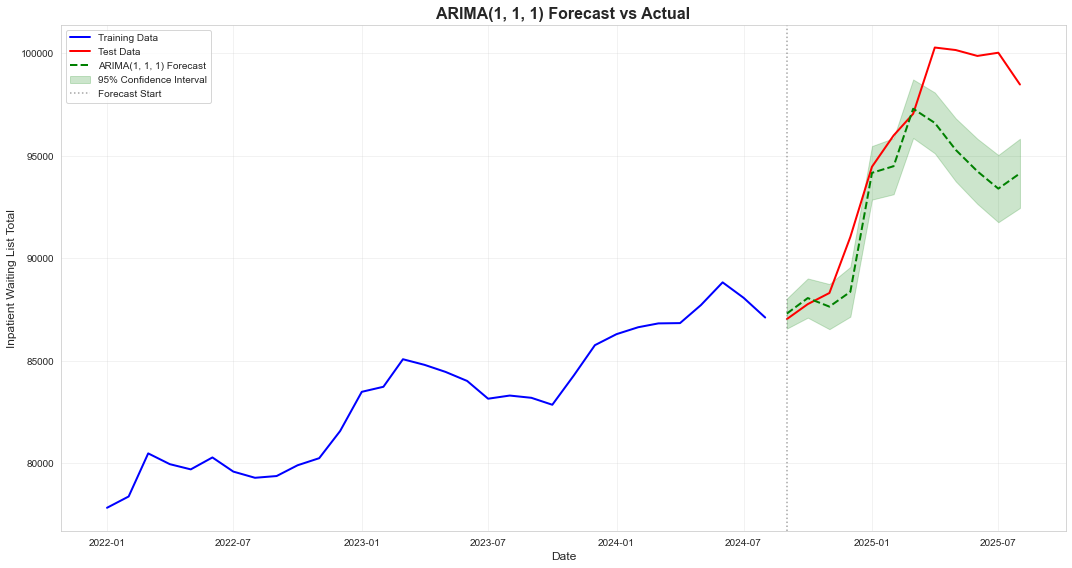

In [159]:

if best_model is not None:
    print("FORECASTING AND EVALUATION")
    print("=" * 50)
    
    # Generate forecasts
    forecast_steps = len(test_ts)
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    
    # Extract predictions and confidence intervals
    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    
    # Calculate metrics
    mae = mean_absolute_error(test_ts, forecast_mean)
    rmse = np.sqrt(mean_squared_error(test_ts, forecast_mean))
    mape_val = mape(test_ts, forecast_mean)
    smape_val = smape(test_ts, forecast_mean)
    
    # Naive forecast for comparison
    naive_pred = naive_forecast(np.concatenate([train_ts, test_ts]))[len(train_ts):]
    mase_val = mase(test_ts, forecast_mean, naive_pred)
    
    # Prediction interval coverage
    coverage = prediction_interval_coverage(test_ts, conf_int.iloc[:, 0], conf_int.iloc[:, 1])
    
    print(f"FORECAST METRICS:")
    print(f"   MAE:  {mae:,.0f}")
    print(f"   RMSE: {rmse:,.0f}")
    print(f"   MAPE: {mape_val:.2f}%")
    print(f"   sMAPE: {smape_val:.2f}%")
    print(f"   MASE: {mase_val:.3f}")
    print(f"   95% PI Coverage: {coverage:.1f}%")
    
    # Plot results
    plt.figure(figsize=(15, 8))
    
    # Plot historical data
    plt.plot(train_ts.index, train_ts.values, label='Training Data', color='blue', linewidth=2)
    plt.plot(test_ts.index, test_ts.values, label='Test Data', color='red', linewidth=2)
    
    # Plot forecasts
    plt.plot(forecast_mean.index, forecast_mean.values, label=f'ARIMA{best_order} Forecast', 
             color='green', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                     color='green', alpha=0.2, label='95% Confidence Interval')
    
    # Add vertical line at forecast start
    plt.axvline(test_ts.index[0], color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
    
    plt.title(f'ARIMA{best_order} Forecast vs Actual', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inpatient Waiting List Total', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df = pd.DataFrame({
        'Date': forecast_mean.index,
        'Actual': test_ts.values,
        'Forecast': forecast_mean.values,
        'Lower_95': conf_int.iloc[:, 0].values,
        'Upper_95': conf_int.iloc[:, 1].values
    })
    
    results_df.to_csv(outdir / 'forecast_results.csv', index=False)
    
    # Save metrics
    metrics = {
        'Model': f'ARIMA{best_order}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'MASE': mase_val,
        'Coverage_95': coverage,
        'AIC': best_model.aic,
        'BIC': best_model.bic
    }
    
    pd.DataFrame([metrics]).to_csv(outdir / 'model_metrics.csv', index=False)


# 11. Future Forecasts (Next 1 Year - 12 Months)


FUTURE FORECAST (Next 12 Months)
Last available data: August 2025
Forecast period: September 2025 to August 2026
Future Forecasts (Next 12 Months):


,Date,Forecast,Lower_95,Upper_95
0,2025-09-01,98423.0,96468.0,100377.0
1,2025-10-01,98396.0,95575.0,101217.0
2,2025-11-01,98380.0,94876.0,101885.0
3,2025-12-01,98371.0,94282.0,102460.0
4,2026-01-01,98366.0,93759.0,102973.0
5,2026-02-01,98363.0,93286.0,103440.0
6,2026-03-01,98361.0,92853.0,103869.0
7,2026-04-01,98360.0,92450.0,104270.0
8,2026-05-01,98359.0,92073.0,104645.0
9,2026-06-01,98359.0,91717.0,105001.0


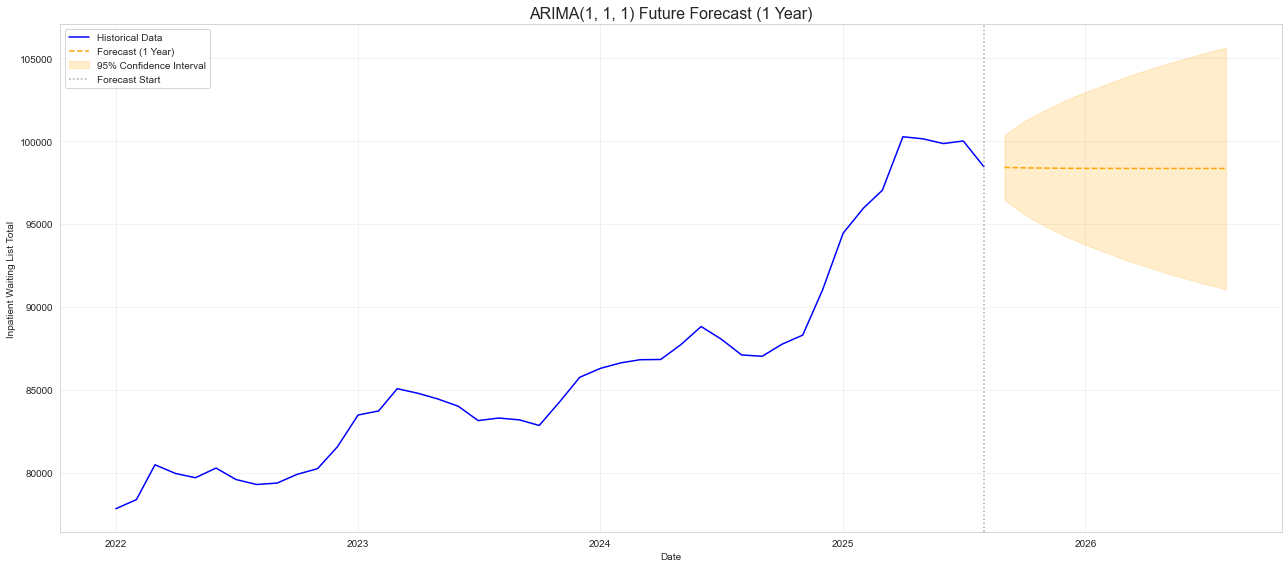

Summary (Next 12 Months):
   Start: 98,423
   End: 98,359
   Change: -64
   Avg Monthly Change: -5
   Min Forecast: 98,359
   Max Forecast: 98,423


In [137]:
if best_model is not None:
    print("FUTURE FORECAST (Next 12 Months)")
    print("=" * 50)
    
    # Ensure 'y' column exists
    if 'y' not in df.columns:
        df['y'] = pd.to_numeric(df['Total Patients Waiting List'], errors='coerce')
        df.dropna(subset=['y'], inplace=True)

    # Refit model on full dataset
    full_ts = df.set_index('ds')['y']
    final_model = ARIMA(full_ts, order=best_order).fit()
    
    # Forecast next 12 months
    future_forecast = final_model.get_forecast(steps=12)
    future_mean = future_forecast.predicted_mean
    future_conf = future_forecast.conf_int(alpha=0.05)
    
    # Future dates
    last_date = full_ts.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
    
    print(f"Last available data: {last_date.strftime('%B %Y')}")
    print(f"Forecast period: {future_dates[0].strftime('%B %Y')} to {future_dates[-1].strftime('%B %Y')}")
    
    # Forecast DataFrame
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Forecast': future_mean.values,
        'Lower_95': future_conf.iloc[:, 0].values,
        'Upper_95': future_conf.iloc[:, 1].values
    })
    
    print("Future Forecasts (Next 12 Months):")
    display(future_df.round(0))
    
    # Plot
    plt.figure(figsize=(18, 8))
    plt.plot(full_ts.index, full_ts.values, label='Historical Data', color='blue')
    plt.plot(future_dates, future_mean.values, label='Forecast (1 Year)', color='orange', linestyle='--')
    plt.fill_between(future_dates, future_conf.iloc[:, 0], future_conf.iloc[:, 1],
                     color='orange', alpha=0.2, label='95% Confidence Interval')
    plt.axvline(last_date, color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
    
    plt.title(f'ARIMA{best_order} Future Forecast (1 Year)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Inpatient Waiting List Total')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("Summary (Next 12 Months):")
    print(f"   Start: {future_mean.iloc[0]:,.0f}")
    print(f"   End: {future_mean.iloc[-1]:,.0f}")
    print(f"   Change: {future_mean.iloc[-1] - future_mean.iloc[0]:,.0f}")
    print(f"   Avg Monthly Change: {(future_mean.iloc[-1] - future_mean.iloc[0]) / 12:,.0f}")
    print(f"   Min Forecast: {future_mean.min():,.0f}")
    print(f"   Max Forecast: {future_mean.max():,.0f}")

    # Save if needed
    # future_df.to_csv(outdir / 'future_forecast_1year.csv', index=False)

In [142]:
# Define the models first
arima_model = ARIMA(train_ts, order=(1,1,1)).fit()
sarima_model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

# Then print
print(f"ARIMA AIC: {arima_model.aic:.2f}, BIC: {arima_model.bic:.2f}")
print(f"SARIMA AIC: {sarima_model.aic:.2f}, BIC: {sarima_model.bic:.2f}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97770D+00    |proj g|=  2.91396D+00

At iterate    5    f=  4.78905D+00    |proj g|=  1.74889D-02

At iterate   10    f=  4.78729D+00    |proj g|=  3.16764D-01


 This problem is unconstrained.



At iterate   15    f=  4.78065D+00    |proj g|=  1.80697D-02

At iterate   20    f=  4.78057D+00    |proj g|=  8.38068D-04

At iterate   25    f=  4.78053D+00    |proj g|=  1.67090D-02

At iterate   30    f=  4.78018D+00    |proj g|=  7.59735D-03

At iterate   35    f=  4.78012D+00    |proj g|=  1.66554D-03

At iterate   40    f=  4.78010D+00    |proj g|=  2.53909D-03

At iterate   45    f=  4.78010D+00    |proj g|=  3.72845D-04

At iterate   50    f=  4.78005D+00    |proj g|=  1.71404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   1.714D-03   4.780D+00
  F =   4.78005331801

In [147]:
# Generate forecasts with confidence intervals
arima_fc = arima_model.get_forecast(steps=len(test_ts))
arima_forecast = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int()

sarima_fc = sarima_model.get_forecast(steps=len(test_ts))
sarima_forecast = sarima_fc.predicted_mean
sarima_ci = sarima_fc.conf_int()

# Then calculate metrics
arima_mae = mean_absolute_error(test_ts, arima_forecast)
sarima_mae = mean_absolute_error(test_ts, sarima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_ts, arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test_ts, sarima_forecast))
arima_interval_width = (arima_ci.iloc[:, 1] - arima_ci.iloc[:, 0]).mean()
sarima_interval_width = (sarima_ci.iloc[:, 1] - sarima_ci.iloc[:, 0]).mean()

print("MODEL COMPARISON RESULTS")
print("=" * 30)
print(f"ARIMA MAE:   {arima_mae:.2f}")
print(f"SARIMA MAE:  {sarima_mae:.2f}")
print(f"ARIMA RMSE:  {arima_rmse:.2f}")
print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"ARIMA Avg 95% PI Width:  {arima_interval_width:.2f}")
print(f"SARIMA Avg 95% PI Width: {sarima_interval_width:.2f}")

MODEL COMPARISON RESULTS
ARIMA MAE:   8003.06
SARIMA MAE:  4226.66
ARIMA RMSE:  9424.45
SARIMA RMSE: 5082.77
ARIMA Avg 95% PI Width:  8245.26
SARIMA Avg 95% PI Width: 8685.58
